In [1]:
import pandas as pd
import spacy
from tqdm import tqdm

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt

2023-03-07 15:48:30.958163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:48:31.706839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 15:48:31.706862: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 15:48:33.951994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
newsFile = "dataset/news.tsv"
newsDf = pd.read_csv(newsFile, header=None, sep="\t", skiprows = 0, nrows=500, names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

In [3]:
newsDf

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
...,...,...,...,...,...,...,...,...
495,N91034,movies,movievideo,Trailer - Harriet,Trailer 1,https://assets.msn.com/labs/mind/AAENS65.html,[],[]
496,N72549,lifestyle,lifestyleparenting,Most popular baby names in America,"To help understand which names dominate today,...",https://assets.msn.com/labs/mind/AABbEKL.html,"[{""Label"": ""United States"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""Social Security Administration"", ""..."
497,N51071,sports,football_nfl,Execution-style murder in Iron Range woods dra...,A 19-year-old who in a jealous rage killed an ...,https://assets.msn.com/labs/mind/AAJwplz.html,"[{""Label"": ""Iron Range"", ""Type"": ""U"", ""Wikidat...","[{""Label"": ""Hibbing, Minnesota"", ""Type"": ""G"", ..."
498,N78784,video,animals,This Park In America Has Cacti So Big Birds Li...,There's a park in America where birds live ins...,https://assets.msn.com/labs/mind/AAI3adG.html,[],[]


In [13]:
len((newsDf[newsDf["abstract_entities"] == "[]"])["abstract_entities"])

203

In [15]:
print(newsDf["abstract_entities"][1])
print(newsDf["title_entities"][1])

[{"Label": "IPad", "Type": "J", "WikidataId": "Q2796", "Confidence": 0.999, "OccurrenceOffsets": [12], "SurfaceForms": ["iPad"]}, {"Label": "Apple Inc.", "Type": "O", "WikidataId": "Q312", "Confidence": 0.999, "OccurrenceOffsets": [0], "SurfaceForms": ["Apple"]}]
[{"Label": "IPad", "Type": "J", "WikidataId": "Q2796", "Confidence": 0.999, "OccurrenceOffsets": [42], "SurfaceForms": ["iPads"]}, {"Label": "Walmart", "Type": "O", "WikidataId": "Q483551", "Confidence": 1.0, "OccurrenceOffsets": [0], "SurfaceForms": ["Walmart"]}]


In [4]:
title = newsDf['title'][0]
abstract = newsDf['abstract'][0]
title_entities = newsDf['title_entities'][0]
print(title)
print(abstract)
print(title_entities)

The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
Shop the notebooks, jackets, and more that the royals can't live without.
[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]


In [5]:
nlp = spacy.load('en_core_web_sm')

In [8]:
from collections import Counter
from string import punctuation
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result # 5

In [12]:
output = set(get_hotwords(title + " " + abstract))
print(output)

{'charles', 'queen', 'brands', 'prince', 'philip', 'jackets', 'royals', 'elizabeth', 'shop', 'notebooks'}


In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [7]:
doc = nlp(abstract)

for tok in doc:
  print(tok.text, "...", tok.dep_)

Shop ... ROOT
the ... det
notebooks ... dobj
, ... punct
jackets ... conj
, ... punct
and ... cc
more ... conj
that ... mark
the ... det
royals ... nsubj
ca ... aux
n't ... neg
live ... ccomp
without ... prep
. ... punct


In [8]:
for i in range(0,10):
    print(get_entities(str(newsDf['abstract'][i])))

['royals', 'notebooks']
['new iPad releases', 'last  models']
['harmless  habits', 'unwanted belly fat']
['', '']
['. Ivan Molchanets', 'multiple sand holes']
['NBA it', 'nearly  me']
['post', 'first Skin Digest']
['', '']
['week NFL It', 'bad  league']
['you', 'device']


In [9]:
import json

In [10]:
teDict = json.loads(title_entities)
print(teDict)
print(len(teDict))

[{'Label': 'Prince Philip, Duke of Edinburgh', 'Type': 'P', 'WikidataId': 'Q80976', 'Confidence': 1.0, 'OccurrenceOffsets': [48], 'SurfaceForms': ['Prince Philip']}, {'Label': 'Charles, Prince of Wales', 'Type': 'P', 'WikidataId': 'Q43274', 'Confidence': 1.0, 'OccurrenceOffsets': [28], 'SurfaceForms': ['Prince Charles']}, {'Label': 'Elizabeth II', 'Type': 'P', 'WikidataId': 'Q9682', 'Confidence': 0.97, 'OccurrenceOffsets': [11], 'SurfaceForms': ['Queen Elizabeth']}]
3


In [11]:
entity_pairs = []

for i in tqdm(newsDf['title']):
    entity_pairs.append(get_entities(i))

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 106.11it/s]


In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
relations = [get_relation(i) for i in tqdm(newsDf['title'])]
pd.Series(relations).value_counts()[:50]

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 112.11it/s]


's                      13
Is                       7
is                       6
Things                   6
says                     5
say                      4
shows                    4
are                      4
Take                     3
places                   3
Want                     3
takes                    3
Do                       2
make                     2
Photos of                2
Says                     2
causes                   2
Recipes for              2
Tracks                   2
Benefits of              2
have                     2
Questions                2
amused over              2
help                     2
Mistakes                 2
Are                      2
makes                    2
Tips                     2
likely                   2
ways                     2
Wolverines in            2
had                      2
date                     2
Watch                    2
games                    2
Places                   2
dies                     2
B

In [83]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

totalLen = len(target)

for i in range(0, totalLen):
    source.append(source[i])
    relations.append("present in")
    target.append(newsDf['id'][i])
    
    source.append(target[i])
    relations.append("present in")
    target.append(newsDf['id'][i])

i = 0
while i<len(source):
    if(source[i] == '' or target[i] == '' or relations[i] == ''):
        source.pop(i)
        target.pop(i)
        relations.pop(i)
    else:
        i += 1

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [84]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

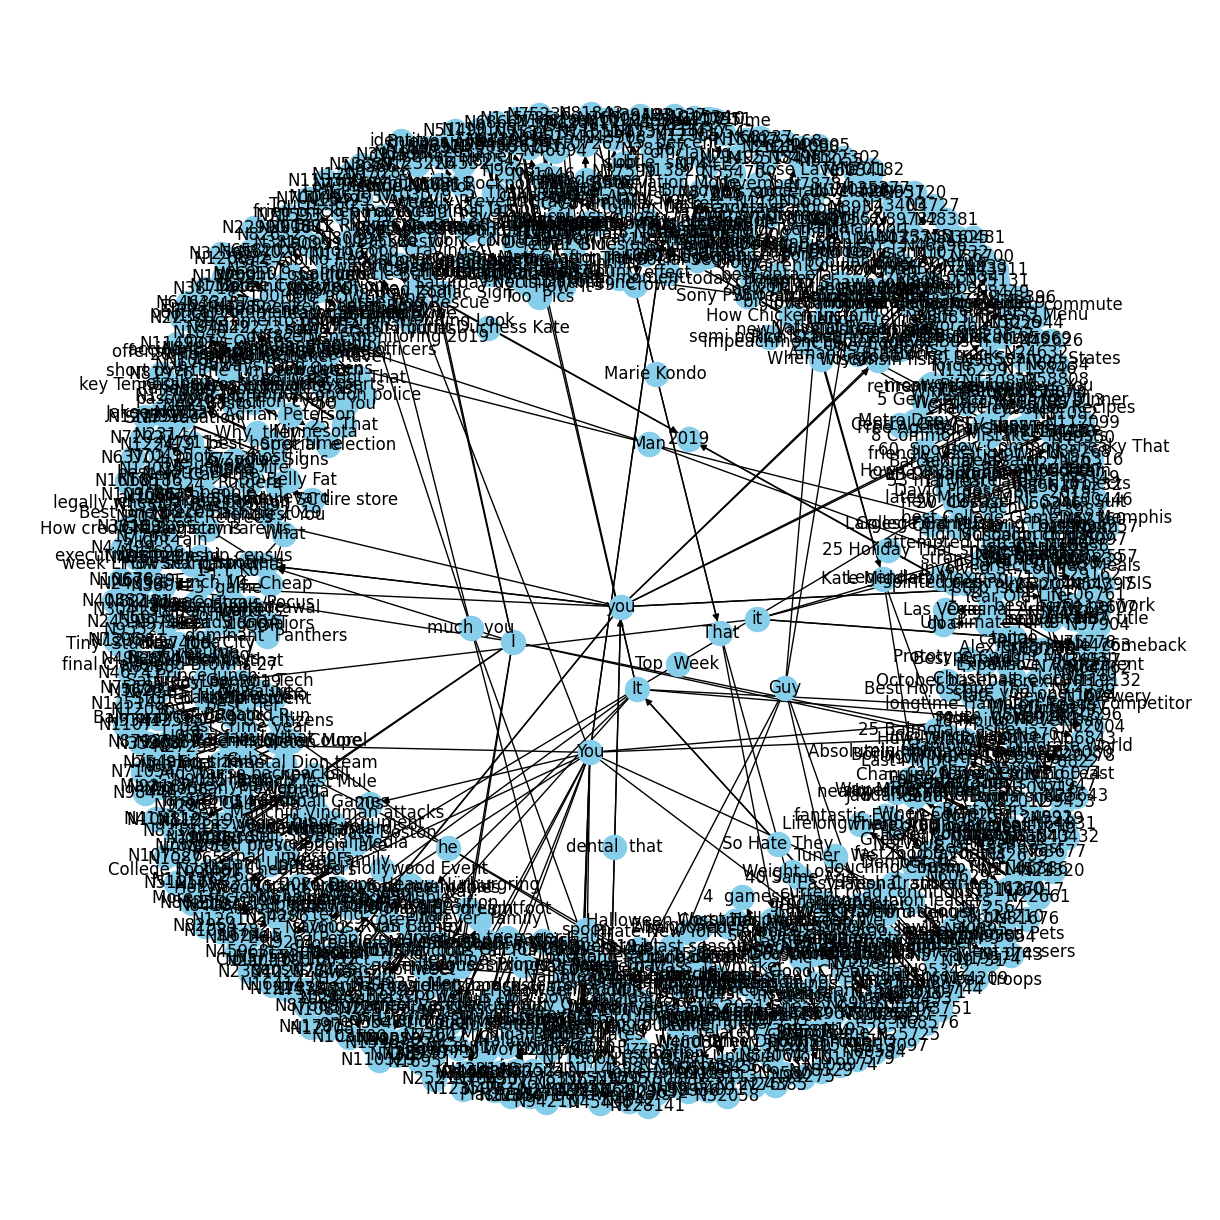

In [85]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

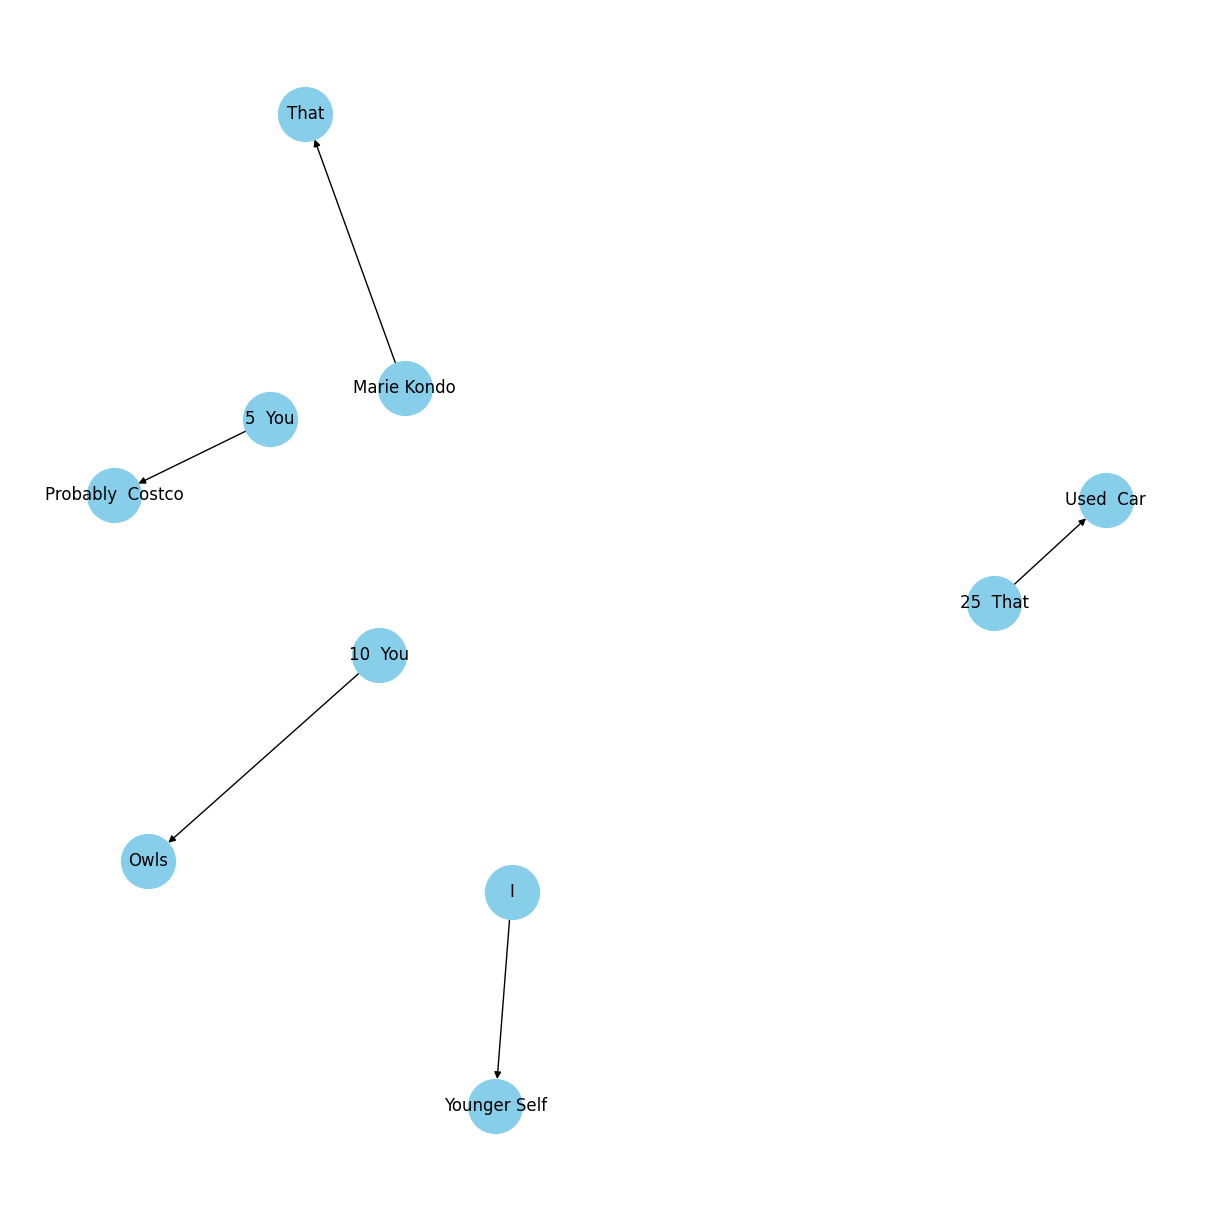

In [86]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Things"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()